<a href="https://colab.research.google.com/github/kimala33/AIFFEL_quest_cr/blob/main/%EC%9E%A5%EB%A5%B4%EA%B5%AD%EA%B0%801.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

In [ ]:
#구글드라이브 마운트하기
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#데이터셋 읽기
import pandas as pd
file_name_list = ['netflix_titles', 'disney_plus_titles', 'amazon_prime_titles']
root_path = '/content/drive/My Drive/aiffel/'
file_ext = 'csv'
# 여러 파일을 읽어서 하나의 데이터프레임으로 합치기
dataframes = []  # 데이터를 저장할 리스트

for file_name in file_name_list:
    file_path = f"{root_path}{file_name}.{file_ext}"  # 경로 생성
    df = pd.read_csv(file_path)  # CSV 파일 읽기

    # 파일명을 가공해 새로운 필드 추가
    platform_name = file_name.split('_titles')[0]  # '_titles' 앞부분 추출
    df['platform'] = platform_name  # 새로운 열 추가

    # 필요한 열만 선택하고 순서 정렬
    df = df[['platform', 'country', 'listed_in']]

    dataframes.append(df)  # 리스트에 추가

# 데이터프레임 결합
combined_data = pd.concat(dataframes, ignore_index=True)

# 결과 확인
from tabulate import tabulate
print(tabulate(combined_data.head(), headers='keys', tablefmt='grid'))

print(len(combined_data))

+----+------------+---------------+---------------------------------------------------------------+
|    | platform   | country       | listed_in                                                     |
+====+============+===============+===============================================================+
|  0 | netflix    | United States | Documentaries                                                 |
+----+------------+---------------+---------------------------------------------------------------+
|  1 | netflix    | South Africa  | International TV Shows, TV Dramas, TV Mysteries               |
+----+------------+---------------+---------------------------------------------------------------+
|  2 | netflix    | nan           | Crime TV Shows, International TV Shows, TV Action & Adventure |
+----+------------+---------------+---------------------------------------------------------------+
|  3 | netflix    | nan           | Docuseries, Reality TV                                        |


In [ ]:
# 결측치 제거: 'country', 'listed_in' 필드 중 하나라도 결측치가 있으면 삭제
combined_data = combined_data.dropna(subset=['country', 'listed_in'])

# 결과 확인
from tabulate import tabulate
print(tabulate(combined_data.head(), headers='keys', tablefmt='grid'))
print(combined_data.shape)

+----+------------+-----------------------------------------------------------------------+--------------------------------------------------------+
|    | platform   | country                                                               | listed_in                                              |
+====+============+=======================================================================+========================================================+
|  0 | netflix    | United States                                                         | Documentaries                                          |
+----+------------+-----------------------------------------------------------------------+--------------------------------------------------------+
|  1 | netflix    | South Africa                                                          | International TV Shows, TV Dramas, TV Mysteries        |
+----+------------+-----------------------------------------------------------------------+---------------

In [ ]:
#자연어처리 모듈
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
import difflib
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt

# WordNetLemmatizer 초기화
lemmatizer = WordNetLemmatizer()

# 유사한 장르를 그룹화하는 함수
def group_similar_genres(genres, threshold=0.8):
    unique_genres = list(set(genres))  # 고유한 장르 목록
    grouped_genres = {}

    for genre in unique_genres:
        # 복수형을 단수형으로 변환
        genre_singular = lemmatizer.lemmatize(genre.lower())
        matched = False
        for key in grouped_genres:
            # 유사도 계산 (difflib)
            similarity = difflib.SequenceMatcher(None, genre_singular, key.lower()).ratio()
            if similarity >= threshold:
                grouped_genres[key].append(genre)
                matched = True
                break
        if not matched:
            grouped_genres[genre_singular] = [genre]

    # 그룹화된 결과 반환
    return grouped_genres

# 원핫 인코딩 열을 만들 때, 그룹화된 필드명에 대해 원핫 인코딩을 적용
def generate_one_hot_encoding(df, grouped_fields):
    unique_field_groups = list(grouped_fields.keys())

    # 원핫 인코딩 열 생성
    for field_group in unique_field_groups:
        column_name = f'genre_{field_group.replace(" ", "_")}'
        df[column_name] = df['genres'].apply(
            lambda x: 1 if any(g.lower() in map(str.lower, grouped_fields[field_group]) for g in x) else 0
        )

    return df

In [ ]:
#1. 장르명 그룹화
combined_data['genres'] = combined_data['listed_in'].apply(lambda x: x.split(', ') if pd.notna(x) else [])

# 장르 목록을 combined_data에서 가져오는 예시 (combined_data['genres']에 장르 목록이 있다고 가정)
all_genres = [genre for genres in combined_data['genres'] for genre in genres]

# 유사한 장르명 그룹화
grouped_genres = group_similar_genres(all_genres, threshold=0.8)

gropped_data = combined_data.copy()

# 원본 데이터프레임에서 원핫 인코딩 적용
gropped_data = generate_one_hot_encoding(gropped_data, grouped_genres)


#2. 국가명 그룹화
gropped_data['make_country'] = gropped_data['country'].apply(lambda x: x.split(',') if pd.notna(x) else [])

# 원본 데이터프레임에서 원핫 인코딩 적용
from sklearn.preprocessing import MultiLabelBinarizer

# 원본 데이터프레임 복사
gropped_data_copy = gropped_data.copy()

# MultiLabelBinarizer 초기화
mlb = MultiLabelBinarizer()

# 원핫 인코딩 적용(국가명은 알파벳 순서로 정렬됨)
country_one_hot = pd.DataFrame(mlb.fit_transform(gropped_data_copy['make_country']),
                               columns=mlb.classes_,
                               index=gropped_data_copy.index)

# 원핫 인코딩 데이터프레임을 복사본 데이터프레임과 결합
gropped_data = pd.concat([gropped_data_copy, country_one_hot], axis=1)

# 결과 확인
print("원핫 인코딩된 데이터프레임:")
print(tabulate(gropped_data.head(), headers='keys', tablefmt='grid'))
print(f"데이터프레임 크기: {gropped_data.shape}")

원핫 인코딩된 데이터프레임:
+----+------------+-----------------------------------------------------------------------+--------------------------------------------------------+----------------------------------------------------------------+-----------------+------------------------------+------------------+----------------+------------------+---------------+---------------+----------------------+-------------------+------------------------+--------------------------+----------------+-------------------+--------------------+---------------+--------------------------+-----------------------------------+-----------------------------+-------------------+----------------------+------------------------+----------------------------------+------------------------------+--------------------------------------+---------------+-----------------------------------+----------------------+------------------+-----------------+----------------+-----------------------+--------------------------+--------------------

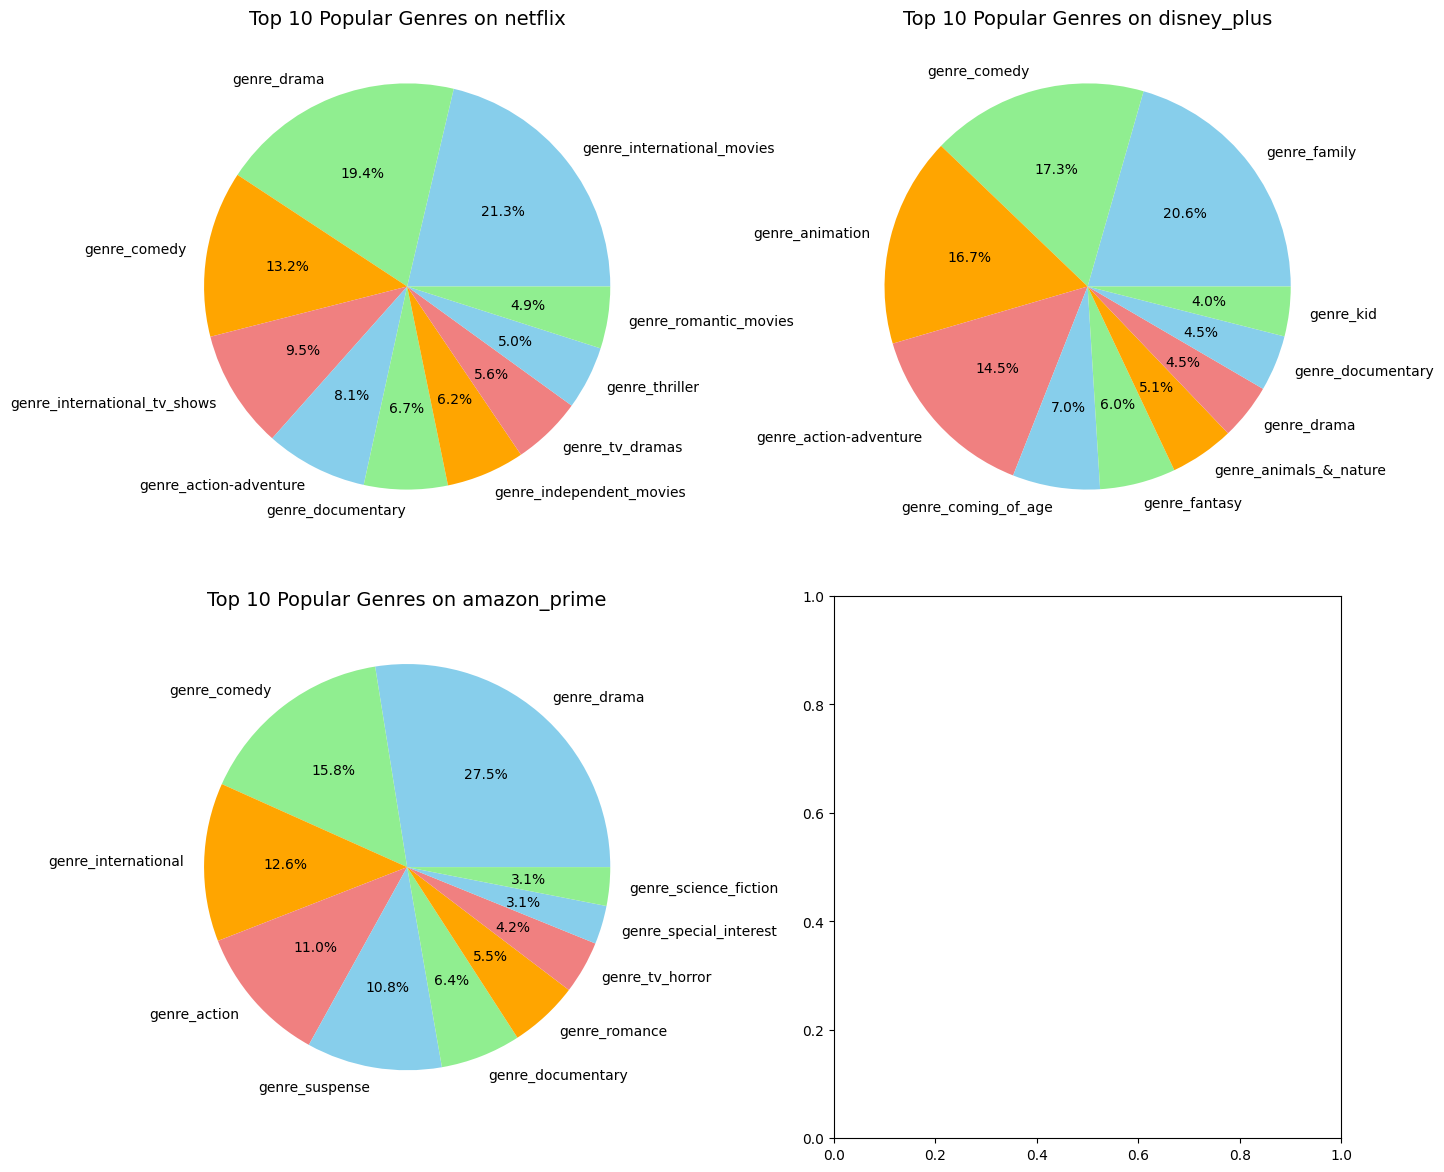

In [ ]:
#각 플랫폼별로 한국콘텐츠 중 인기있는 장르 분석

import matplotlib.pyplot as plt

# 1. 콘텐츠 필터링
korean_content_data = gropped_data

# 2. 플랫폼 목록 추출
platforms = korean_content_data['platform'].unique()

# 3. 각 플랫폼에 대해 상위 4개 장르 시각화
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

top_ranking = 10
# 4. 각 플랫폼에 대해 서브플롯에 차트 추가
for i, platform in enumerate(platforms):
    # 각 서브플롯 위치
    ax = axes[i // 2, i % 2]  # 2x2 배열로 서브플롯 배치
    platform_data = korean_content_data[korean_content_data['platform'] == platform]

    # 5. 장르를 나타내는 'genre_'로 시작하는 컬럼을 필터링
    genre_columns = [col for col in platform_data.columns if col.startswith('genre_')]

    # 6. 각 장르에 대해 1인 값만 추출하여 해당 장르가 포함된 콘텐츠 카운트
    genre_counts = platform_data[genre_columns].sum()

    # 7. 상위 4개 장르 추출
    top_4_genres = genre_counts.sort_values(ascending=False).head(top_ranking)

    # 8. 파이 차트 시각화
    top_4_genres.plot(kind='pie', autopct='%1.1f%%', colors=['skyblue', 'lightgreen', 'orange', 'lightcoral'], ax=ax)
    ax.set_title(f'Top {top_ranking} Popular Genres on {platform}', fontsize=14)
    ax.set_ylabel('')  # y축 레이블 제거

# 9. 레이아웃 조정
plt.tight_layout()
plt.show()

각 플랫폼별 제작 국가 데이터:
platform                    
amazon_prime  United States     292
              India             238
              United Kingdom     48
               United States     42
              Canada             25
                               ... 
netflix        Ecuador            1
              Iran                1
              Cyprus              1
               Mongolia           1
               Montenegro         1
Name: make_country, Length: 322, dtype: int64


<ipython-input-44-1e3aa5fa6227>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=ax, x=platform_countries.index, y=platform_countries.values, palette="viridis")
<ipython-input-44-1e3aa5fa6227>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=ax, x=platform_countries.index, y=platform_countries.values, palette="viridis")
<ipython-input-44-1e3aa5fa6227>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=ax, x=platform_countries.index, y=platform_countries.values, palette="viridis")


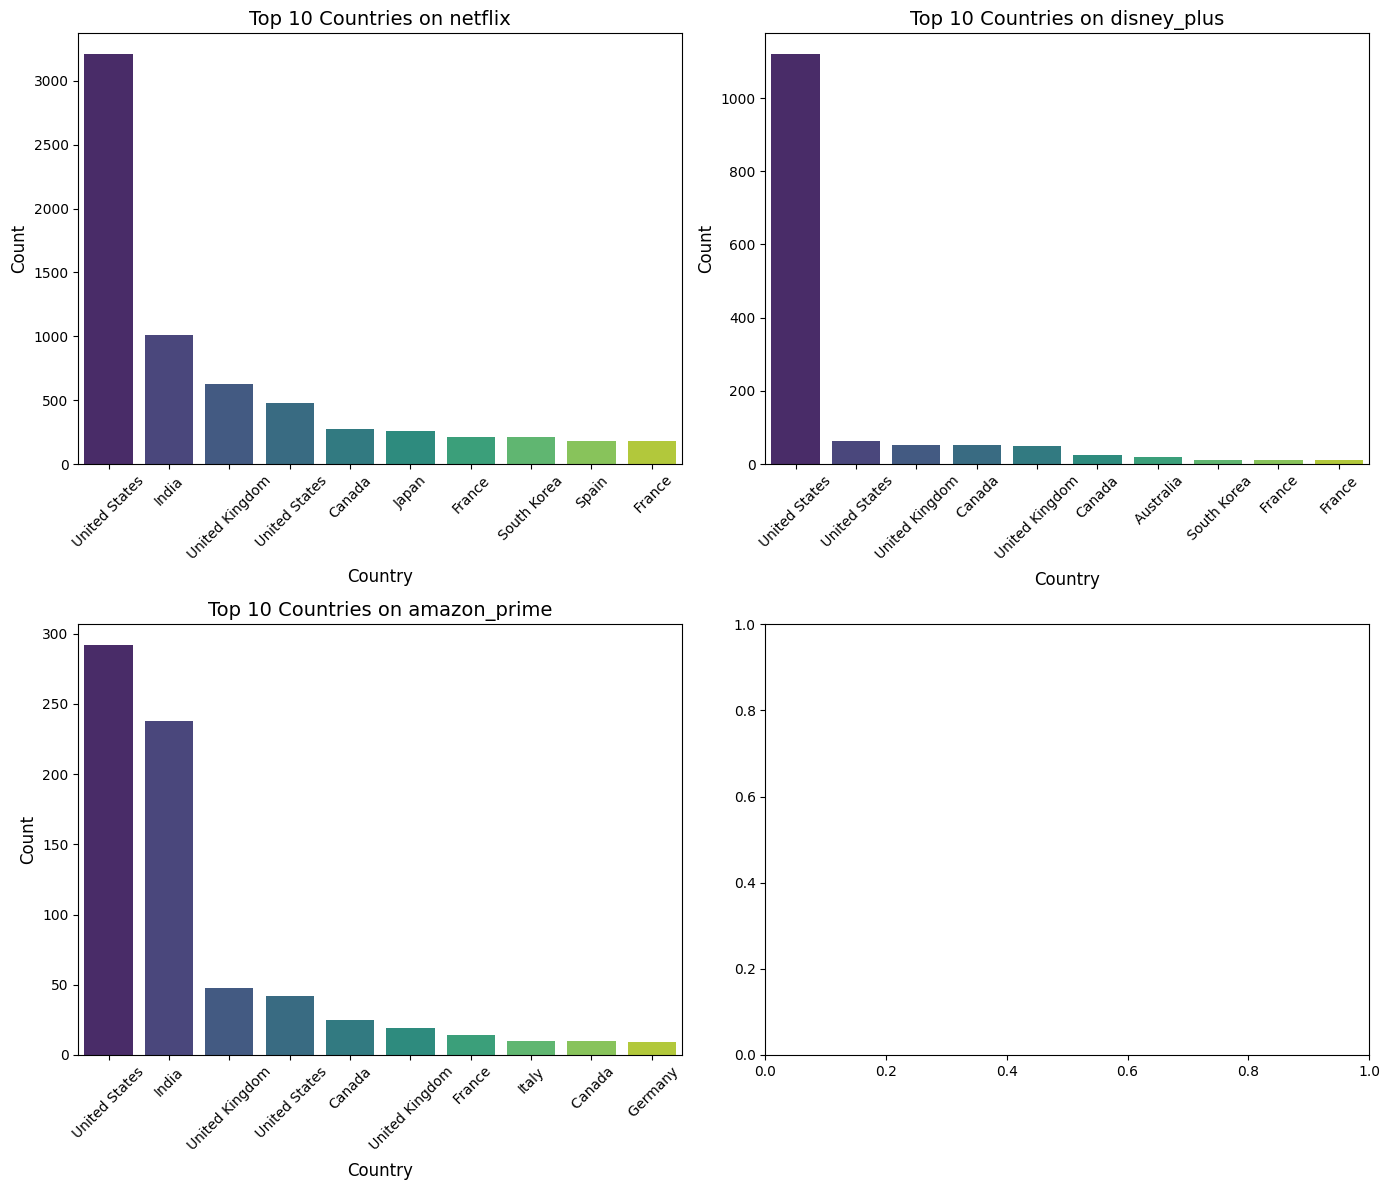

In [ ]:
# 각 플랫폼에서 제작된 국가 전체를 분석
country_counts = gropped_data.groupby(['platform'])['make_country'].apply(lambda x: x.explode().value_counts())

print("각 플랫폼별 제작 국가 데이터:")
print(country_counts)

# 국가별 콘텐츠 분석 및 시각화
# 1. 플랫폼 목록 추출
platforms = gropped_data['platform'].unique()

# 2. 각 플랫폼에 대해 상위 10개 국가 시각화 (히스토그램 형식, x축과 y축 바꿈)
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

for i, platform in enumerate(platforms):
    # 각 서브플롯 위치
    ax = axes[i // 2, i % 2]  # 2x2 배열로 서브플롯 배치
    platform_countries = country_counts[platform]

    # 상위 10개 국가 데이터 추출
    platform_countries = platform_countries.sort_values(ascending=False).head(10)

    # 히스토그램 시각화
    sns.barplot(ax=ax, x=platform_countries.index, y=platform_countries.values, palette="viridis")
    ax.set_title(f"Top 10 Countries on {platform}", fontsize=14)
    ax.set_xlabel("Country", fontsize=12)
    ax.set_ylabel("Count", fontsize=12)
    ax.tick_params(axis='x', rotation=45)

# 레이아웃 조정
plt.tight_layout()
plt.show()

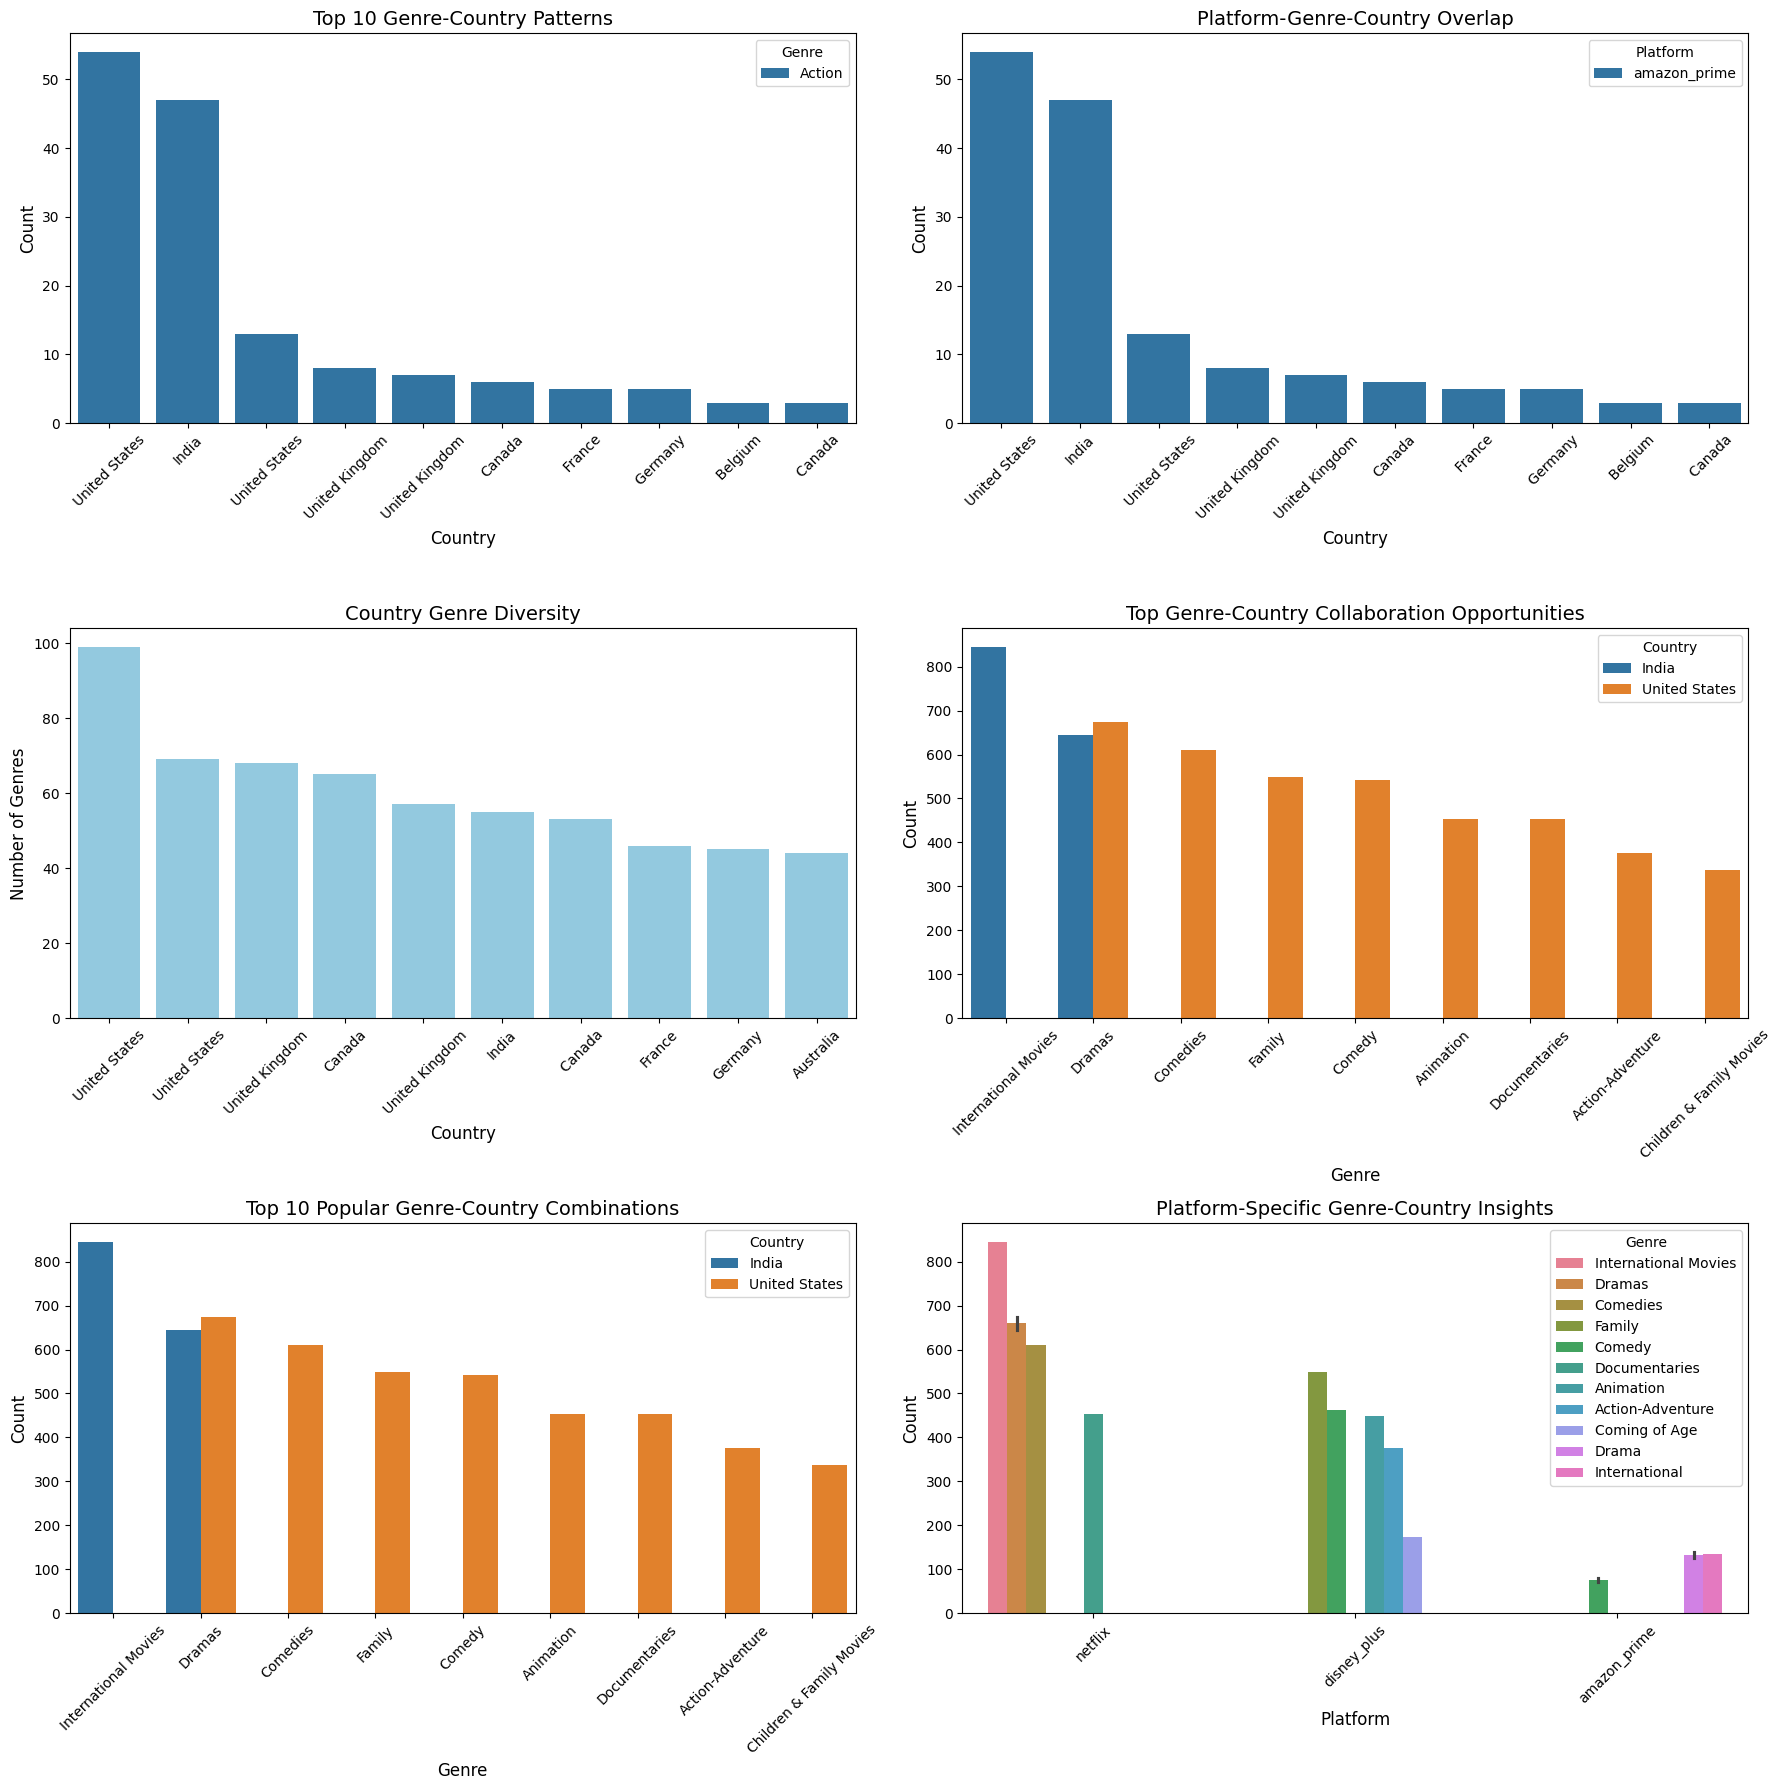

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 장르별 제작국가 매핑 데이터 생성
def create_genre_country_edges(data):
    edges = []
    for _, row in data.iterrows():
        platform = row['platform']
        genres = row['genres']
        countries = row['make_country']
        for genre in genres:
            for country in countries:
                edges.append((platform, genre, country))
    return pd.DataFrame(edges, columns=['platform', 'genre', 'country'])

# 장르와 제작국가 엣지 데이터 생성
edges_df = create_genre_country_edges(gropped_data)

# 3x2 레이아웃으로 그래프 시각화
fig, axes = plt.subplots(3, 2, figsize=(18, 18))

# 1. 장르별 콘텐츠 제작 국가 패턴
pattern_data = edges_df.groupby('genre')['country'].value_counts().reset_index(name='count').head(10)
sns.barplot(ax=axes[0, 0], x=pattern_data['country'], y=pattern_data['count'], hue=pattern_data['genre'])
axes[0, 0].set_title("Top 10 Genre-Country Patterns", fontsize=14)
axes[0, 0].set_xlabel("Country", fontsize=12)
axes[0, 0].set_ylabel("Count", fontsize=12)
axes[0, 0].legend(title="Genre")
axes[0, 0].tick_params(axis='x', rotation=45)

# 2. 플랫폼 간 제작 국가와 장르의 공유성
shared_data = edges_df.groupby(['platform', 'genre'])['country'].value_counts().reset_index(name='count').head(10)
sns.barplot(ax=axes[0, 1], x=shared_data['country'], y=shared_data['count'], hue=shared_data['platform'])
axes[0, 1].set_title("Platform-Genre-Country Overlap", fontsize=14)
axes[0, 1].set_xlabel("Country", fontsize=12)
axes[0, 1].set_ylabel("Count", fontsize=12)
axes[0, 1].legend(title="Platform")
axes[0, 1].tick_params(axis='x', rotation=45)

# 3. 국가별 제작 트렌드와 장르 다양성
trend_data = edges_df.groupby('country')['genre'].nunique().reset_index(name='diversity_count').sort_values(by='diversity_count', ascending=False).head(10)
sns.barplot(ax=axes[1, 0], x=trend_data['country'], y=trend_data['diversity_count'], color="skyblue")
axes[1, 0].set_title("Country Genre Diversity", fontsize=14)
axes[1, 0].set_xlabel("Country", fontsize=12)
axes[1, 0].set_ylabel("Number of Genres", fontsize=12)
axes[1, 0].tick_params(axis='x', rotation=45)

# 4. 글로벌 시장을 위한 협업 가능성
collaboration_data = edges_df.groupby(['genre', 'country']).size().reset_index(name='count').sort_values(by='count', ascending=False).head(10)
sns.barplot(ax=axes[1, 1], x=collaboration_data['genre'], y=collaboration_data['count'], hue=collaboration_data['country'])
axes[1, 1].set_title("Top Genre-Country Collaboration Opportunities", fontsize=14)
axes[1, 1].set_xlabel("Genre", fontsize=12)
axes[1, 1].set_ylabel("Count", fontsize=12)
axes[1, 1].legend(title="Country")
axes[1, 1].tick_params(axis='x', rotation=45)

# 5. 타겟 마케팅 및 배급 전략 수립
popular_data = edges_df.groupby(['genre', 'country']).size().reset_index(name='count').sort_values(by='count', ascending=False).head(10)
sns.barplot(ax=axes[2, 0], x=popular_data['genre'], y=popular_data['count'], hue=popular_data['country'])
axes[2, 0].set_title("Top 10 Popular Genre-Country Combinations", fontsize=14)
axes[2, 0].set_xlabel("Genre", fontsize=12)
axes[2, 0].set_ylabel("Count", fontsize=12)
axes[2, 0].legend(title="Country")
axes[2, 0].tick_params(axis='x', rotation=45)

# 6. 콘텐츠 포트폴리오 차별화
differentiation_data = edges_df.groupby(['platform', 'genre', 'country']).size().reset_index(name='count').sort_values(by='count', ascending=False).groupby('platform').head(5)
sns.barplot(ax=axes[2, 1], x=differentiation_data['platform'], y=differentiation_data['count'], hue=differentiation_data['genre'])
axes[2, 1].set_title("Platform-Specific Genre-Country Insights", fontsize=14)
axes[2, 1].set_xlabel("Platform", fontsize=12)
axes[2, 1].set_ylabel("Count", fontsize=12)
axes[2, 1].legend(title="Genre")
axes[2, 1].tick_params(axis='x', rotation=45)

# Adjust layout for readability
plt.tight_layout()
plt.show()